# Обучение модели

1. Проведите небольшой описательный анализ данных

2. Решите задачу классификации подготовленных данных по определенным ранее вами классам

3. Выберите метрики, по которым будете интерпретировать результат.

4. Объясните ваш выбор метрик

5. Интерпретируйте и визуализируйте полученные результаты

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings 
filterwarnings('ignore')

In [6]:
# создадим dataframe из данных, полученных в задании 3, прочитав все файлы
filename = 'rshb_reviews.csv'
reviews_df = pd.read_csv(filename)

In [7]:
reviews_df.info() # получили 8000 комментариев для обучения модели

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8113 entries, 0 to 8112
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   8113 non-null   object 
 1   url     8113 non-null   object 
 2   text    8113 non-null   object 
 3   score   6359 non-null   float64
 4   date    8113 non-null   object 
 5   label   8113 non-null   object 
dtypes: float64(1), object(5)
memory usage: 380.4+ KB


Данные носят преимущественно текстовый характер.

In [8]:
reviews_df.groupby('label')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
credit,936.0,3.238248,1.885455,1.0,1.0,5.0,5.0,5.0
debitcard,1695.0,2.250147,1.733403,1.0,1.0,1.0,5.0,5.0
deposit,1450.0,2.829655,1.845466,1.0,1.0,2.0,5.0,5.0
hypothec,2278.0,2.346795,1.757852,1.0,1.0,1.0,5.0,5.0


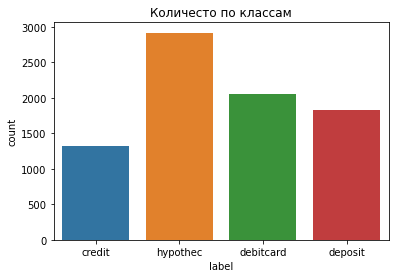

In [9]:
sns.countplot(data=reviews_df, x='label') # как видим, по ипотеке отзывов больше всего
plt.gca().set_title('Количесто по классам')
plt.show()

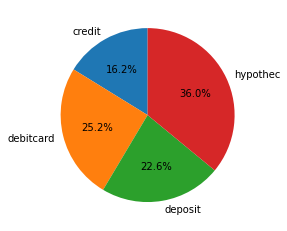

In [10]:
reviews_df.groupby('label').count()['title'].plot.pie(y='label', startangle=90, autopct="%.1f%%")
plt.gca().set_ylabel('')
plt.show()

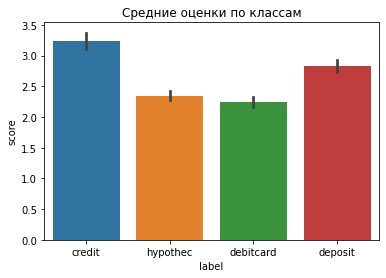

In [11]:
sns.barplot(x='label', y='score', data=reviews_df)
plt.gca().set_title('Средние оценки по классам')
plt.show()

##### Очистка данных

In [12]:
# функция очистки текста от лишних символов
def standartize_text(df, field):
    # переводим всё в нижний регистр
    df[field] = df[field].str.replace(r'[!\"#$%&\'()*+,-./:;<=>?@[\]\^_`{\|}~0-9]', ' ')
    df[field] = df[field].str.lower()
    df[field] = df[field].srt.replace(r'ё', 'е')
    return df

In [13]:
reviews_clear_df = standartize_text(reviews_df, 'text')[['text', 'label']]

In [14]:
reviews_clear_df.head()

,text,label
0,добрый день хочу написать благодарность...,credit
1,добрый день подавал заявки на кредит в банки ...,credit
2,требование решить вопрос о корректном закрытии...,credit
3,осенью г взял потребительский кредит ...,credit
4,здравствуйте хотел бы оставить отзыв о хороше...,credit


Присвоим классам числовые метки:

In [15]:
label_encoding = {'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}

In [16]:
reviews_clear_df['class_label'] = reviews_clear_df['label'].map(label_encoding)

In [17]:
reviews_clear_df.head()

,text,label,class_label
0,добрый день хочу написать благодарность...,credit,0
1,добрый день подавал заявки на кредит в банки ...,credit,0
2,требование решить вопрос о корректном закрытии...,credit,0
3,осенью г взял потребительский кредит ...,credit,0
4,здравствуйте хотел бы оставить отзыв о хороше...,credit,0


### Добавление токенов

In [18]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

reviews_clear_df["tokens"] = reviews_clear_df["text"].apply(tokenizer.tokenize)
reviews_clear_df.head()

,text,label,class_label,tokens
0,добрый день хочу написать благодарность...,credit,0,"[добрый, день, хочу, написать, благодарность, ..."
1,добрый день подавал заявки на кредит в банки ...,credit,0,"[добрый, день, подавал, заявки, на, кредит, в,..."
2,требование решить вопрос о корректном закрытии...,credit,0,"[требование, решить, вопрос, о, корректном, за..."
3,осенью г взял потребительский кредит ...,credit,0,"[осенью, г, взял, потребительский, кредит, в, ..."
4,здравствуйте хотел бы оставить отзыв о хороше...,credit,0,"[здравствуйте, хотел, бы, оставить, отзыв, о, ..."


### Продолжение анализа

In [19]:
def analyze_df_tokens(df, field):
    all_words = [word for tokens in df[field] for word in tokens]
    reviews_lengths = [len(tokens) for tokens in df[field]]
    vocab = sorted(list(set(all_words)))
    print(f'{len(all_words)} всего слов, со словарем размером {len(vocab)}')
    print(f'Максимальная длина отзыва: {max(reviews_lengths)}')
    return all_words, reviews_lengths, vocab
    
all_words, reviews_lengths, _ = analyze_df_tokens(reviews_clear_df, 'tokens')

1308615 всего слов, со словарем размером 52963
Максимальная длина отзыва: 2427


In [20]:
def plot_reviews_lenghts(reviews_lengths, kde=False):
    sns.distplot(reviews_lengths, kde=kde)
    ax = plt.gca()
    ax.set_title('Число отзывов разной длины')
    ax.set_ylabel('Число отзывов')
    ax.set_xlabel('Длина отзыва')

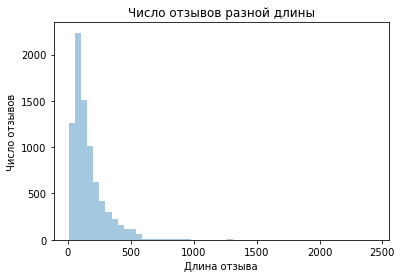

In [21]:
plot_reviews_lenghts(reviews_lengths)

Посмотрим детальнее:

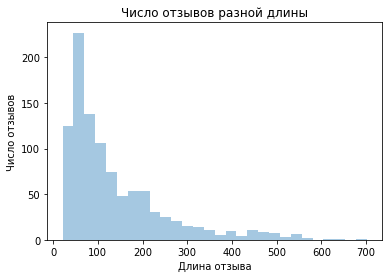

In [22]:
plot_reviews_lenghts(reviews_lengths[:1000])

In [23]:
# Как видно на графике, чаще всего отзывы меньше 200 слов

In [24]:
from collections import Counter
all_words_freq = Counter(all_words)

In [25]:
# самые распространенные слова можно убрать - они вносят шум в модель
all_words_freq.most_common()

[('в', 53597),
 ('и', 40153),
 ('не', 29078),
 ('на', 27112),
 ('что', 21467),
 ('я', 17061),
 ('с', 16722),
 ('по', 14869),
 ('банка', 11167),
 ('мне', 9667),
 ('банк', 8545),
 ('за', 8395),
 ('а', 8269),
 ('к', 7573),
 ('как', 7183),
 ('но', 6746),
 ('все', 6549),
 ('это', 6169),
 ('у', 6126),
 ('меня', 5908),
 ('то', 5391),
 ('так', 5391),
 ('о', 5374),
 ('для', 5192),
 ('от', 4224),
 ('было', 4096),
 ('г', 3971),
 ('же', 3916),
 ('при', 3795),
 ('до', 3696),
 ('уже', 3696),
 ('из', 3514),
 ('нет', 3373),
 ('только', 3290),
 ('день', 3288),
 ('мы', 3267),
 ('очень', 3260),
 ('деньги', 3215),
 ('банке', 3127),
 ('через', 3039),
 ('отделение', 2974),
 ('карту', 2925),
 ('карты', 2802),
 ('офис', 2702),
 ('документы', 2632),
 ('время', 2629),
 ('т', 2593),
 ('кредит', 2569),
 ('после', 2514),
 ('был', 2501),
 ('если', 2493),
 ('она', 2467),
 ('года', 2391),
 ('раз', 2330),
 ('чтобы', 2293),
 ('этом', 2284),
 ('ни', 2264),
 ('была', 2259),
 ('еще', 2232),
 ('бы', 2209),
 ('когда', 2175)

### Очистка текта от стоп-слов

In [26]:
# следует избавиться от слов, которые встречаются чаще других и лемматизировать слова
# для этого можно воспользоваться дополнительными библиотеками
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords # набор стоп-слов

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# список стоп-слов
russian_stopwords = stopwords.words("russian")
russian_stopwords.append('г') # убрать обозначение года

In [28]:
# для удаления стоп-слов из списка токенов
def remove_stop_words_from_list(lst, stpw=russian_stopwords): 
    return [w for w in lst if w not in stpw]

In [29]:
reviews_clear_df['tokens_nstop'] = reviews_clear_df['tokens'].apply(remove_stop_words_from_list)

In [30]:
all_words, reviews_lengths, _ = analyze_df_tokens(reviews_clear_df, 'tokens') # старые слова

1308615 всего слов, со словарем размером 52963
Максимальная длина отзыва: 2427


In [31]:
all_words, reviews_lengths, _ = analyze_df_tokens(reviews_clear_df, 'tokens_nstop') # радикально сократилось число слов

842506 всего слов, со словарем размером 52811
Максимальная длина отзыва: 1528


In [32]:
my_tags = reviews_clear_df['class_label'].unique() # значения классов 

### Лемматизация и определение части речи

In [208]:
from pymorphy2 import MorphAnalyzer

In [209]:
m1 = MorphAnalyzer(lang='ru')

In [210]:
def lemmatize_and_tag_tokens(word_list, morph=m1):
    parse_list = map(morph.parse, word_list)
    return [w[0].normal_form + '_' + w[0].tag.POS for w in parse_list if w[0].tag.POS] 

In [211]:
%%time # выполняется 5-6 минут
reviews_clear_df['tokens_nstop_lemm_pos'] = reviews_clear_df['tokens_nstop'].map(lambda x: lemmatize_and_tag_tokens(x))

Wall time: 5min 46s


In [218]:
print(reviews_clear_df['tokens_nstop_lemm_pos'][0])

['добрый_ADJF', 'день_NOUN', 'хотеть_VERB', 'написать_INFN', 'благодарность_NOUN', 'выражать_VERB', 'благодарность_NOUN', 'сотрудник_NOUN', 'тамбовка_NOUN', 'лущикова_NOUN', 'наталья_NOUN', 'петрович_NOUN', 'лебедев_NOUN', 'екатерина_NOUN', 'юриевич_NOUN', 'ответственный_ADJF', 'плодотворный_ADJF', 'труд_NOUN', 'качественный_ADJF', 'обслуживание_NOUN', 'быстрый_ADJF', 'реагирование_NOUN', 'уважение_NOUN', 'попов_NOUN', 'георгий_NOUN']


### Применение машиинного обучения

Создаём векторное представление

In [33]:
reviews_clear_df.head()

,text,label,class_label,tokens,tokens_nstop
0,добрый день хочу написать благодарность...,credit,0,"[добрый, день, хочу, написать, благодарность, ...","[добрый, день, хочу, написать, благодарность, ..."
1,добрый день подавал заявки на кредит в банки ...,credit,0,"[добрый, день, подавал, заявки, на, кредит, в,...","[добрый, день, подавал, заявки, кредит, банки,..."
2,требование решить вопрос о корректном закрытии...,credit,0,"[требование, решить, вопрос, о, корректном, за...","[требование, решить, вопрос, корректном, закры..."
3,осенью г взял потребительский кредит ...,credit,0,"[осенью, г, взял, потребительский, кредит, в, ...","[осенью, взял, потребительский, кредит, личном..."
4,здравствуйте хотел бы оставить отзыв о хороше...,credit,0,"[здравствуйте, хотел, бы, оставить, отзыв, о, ...","[здравствуйте, хотел, оставить, отзыв, хорошей..."


#### Мешок слов

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer # получаем векторные представления и count_vectorizer

list_corpus = reviews_clear_df["text"].tolist()
list_labels = reviews_clear_df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Визуализируем векторные представления с помощью метода главных компонент:

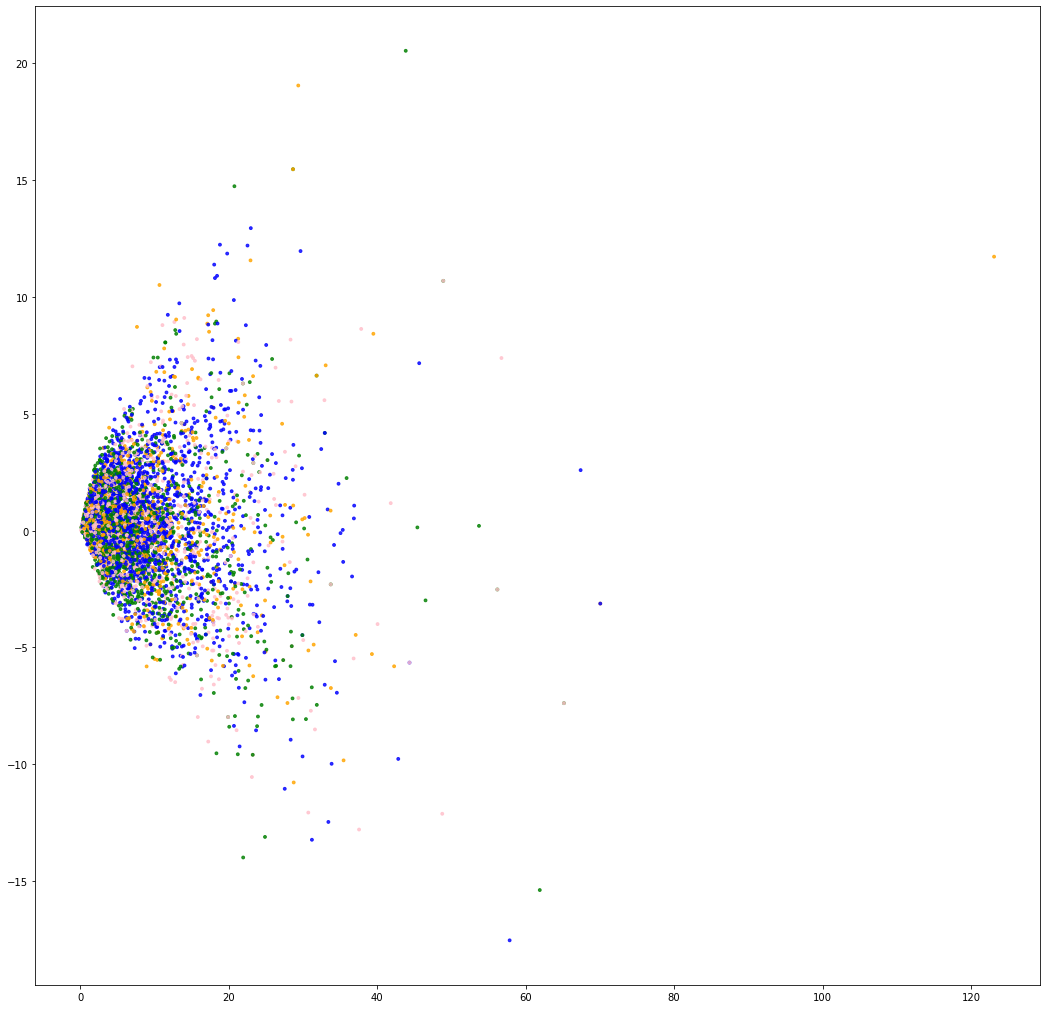

In [35]:
# TODO: GRAPHICS
import numpy as np
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue', 'red', 'green', 'pink']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels,
                    cmap=matplotlib.colors.ListedColormap(colors))

fig = plt.figure(figsize=(18, 18))          
try:    
    plot_LSA(X_train_counts, y_train)
except:
    plot_LSA(X_train_counts, y_train)
plt.show()

На графике видно, что классы почти не отделены друг от друга. Придётся заменить мешок слов на другой метод после оценки модели, построенной на его основе.

Строим модель классификатора

In [36]:
from sklearn.linear_model import LogisticRegression

def train_logreg_model(X_train, y_train):
    logreg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                             multi_class='multinomial', n_jobs=-1, random_state=40)
    print('cls done')
    logreg.fit(X_train, y_train) # может занять около 2-х минут
    print('fit done')
    return logreg

logreg = train_logreg_model(X_train_counts, y_train)
y_predicted_counts = logreg.predict(X_test_counts)

cls done
fit done


Оцениваем классификатор. Поскольку мы используем множественный классификатор, то наиболее главными метриками будут f1 (который включает в себя precision и recall и просто является хорошей общепринятой метрикой), accuracy (можем использовать потому классы разбалансированы, но не сильно), а также матрица ошибок - по ней можно получить понятную и легко интерпретируемую информацию о нашей модели, какие классы она угадывает хорошо, какие плохо, а какие путает между собой.

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools


def eval_prediction(y_test, y_predicted, normalize=False):  
    # tp / (tp + fp) - сколько выбранных значений релевантно
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # tp / (tp + fn) - сколько релевантых значений выбрано
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    # гармоническое среднее precision и recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    # tp + tn/ tp + tn + fp + fn
    accuracy = accuracy_score(y_test, y_predicted)
    
    cm = confusion_matrix(y_test, y_predicted, labels=my_tags)
    plot_confusion_matrix(cm, normalize, 'Матрица ошибок')
    
    return accuracy, precision, recall, f1


def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
             color="black" if cm[i, j] < thresh else "white", fontsize=18)

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy = 0.743, precision = 0.745, recall = 0.743, f1 = 0.744
{'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}


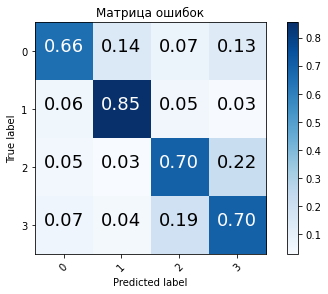

In [38]:
accuracy, precision, recall, f1 = eval_prediction(y_test, y_predicted_counts, True)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")
print(label_encoding)

Метрики довольно сбалансированны, и показаывают примерно одинаковый результат - 75.5% - 76%. Это говорит о том, что модель одинаково хорошо предсказывает большую часть входных данных.

По поводу матрицы ошибок: можно сказать, что ипотеку логистическая регрессия п на мешке слов предсказывает лучше всего - 86% наблюдений. Дебетовые карты и депозиты чаще всего путаются между собой, а хуже всего предсказывается отзыв о кредите - только 66% предсказаний оказываются правильными.

Теперь мы можем попробовать лемматизировать (привести в единую форму) слова, которые остались. Это довольно требовательный процесс, потому можно применить параллелизм

Теперь посмотрим на то, какие слова наиболее важны для нашей модели логистической регрессии при помощи облака слов:

In [39]:
from wordcloud import WordCloud

In [40]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # цикл для каждого класса 
    classes ={}
    for class_index in range(model.coef_.shape[0]): 
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        classes[class_index] = tops
    return classes


def plot_most_important_features(importance, nfeat=4, rows=2, columns=2): # importance - словарь {слово:вес}
    fig = plt.figure(figsize=(10, 8))
    l_dict = {v: k for k, v in label_encoding.items()}
    for i in range(nfeat):
        weight_word_dict = {v:k for k, v in importance[i]}
        fig.add_subplot(rows, columns, i+1)
        wc = WordCloud(background_color='white')
        plt.imshow(wc.fit_words(weight_word_dict), interpolation='bilinear')
        plt.title(f'Класс {l_dict[i]}')
        plt.axis('off')
    plt.tight_layout()

In [41]:
# возьмем 20 самых популярных слов для модели л. регрессии 
importance = get_most_important_features(count_vectorizer, logreg, 20) 

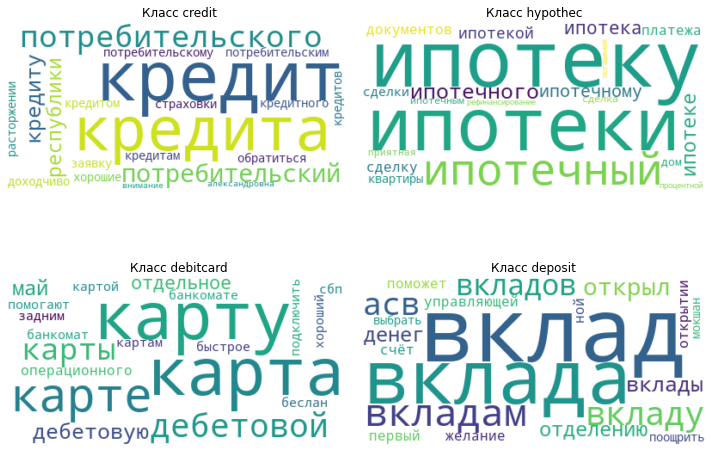

In [42]:
plot_most_important_features(importance) # так и хочется применить лемматизацию 

Как видно по облакам слов, в каждом классе комментариев превалируют названия классов (только на русском). Можно заметить, что слова представлены в разных падежах - это надо исправить лемматизацией.

Поскольку лемматизация на весь датасет займет очень долгое время, мы можем применить лемматизацию точечно, написав функцию, которая лемматизирует выбранные объекты. Можем применить стемминг, он поможет с этим

In [43]:
# для этого воспользуемся стеммингом snowball
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('russian')

In [44]:
stemmed_corpus = reviews_clear_df['tokens'].map(lambda x: [stemmer.stem(i) for i in x]) # 2-3 минуты

In [45]:
stemmed_corpus = stemmed_corpus.map(lambda x: ' '.join(x)).tolist()
list_labels = reviews_clear_df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(stemmed_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts_stemmed, count_vectorizer_stemmed = cv(X_train)
X_test_counts_stemmed = count_vectorizer.transform(X_test)

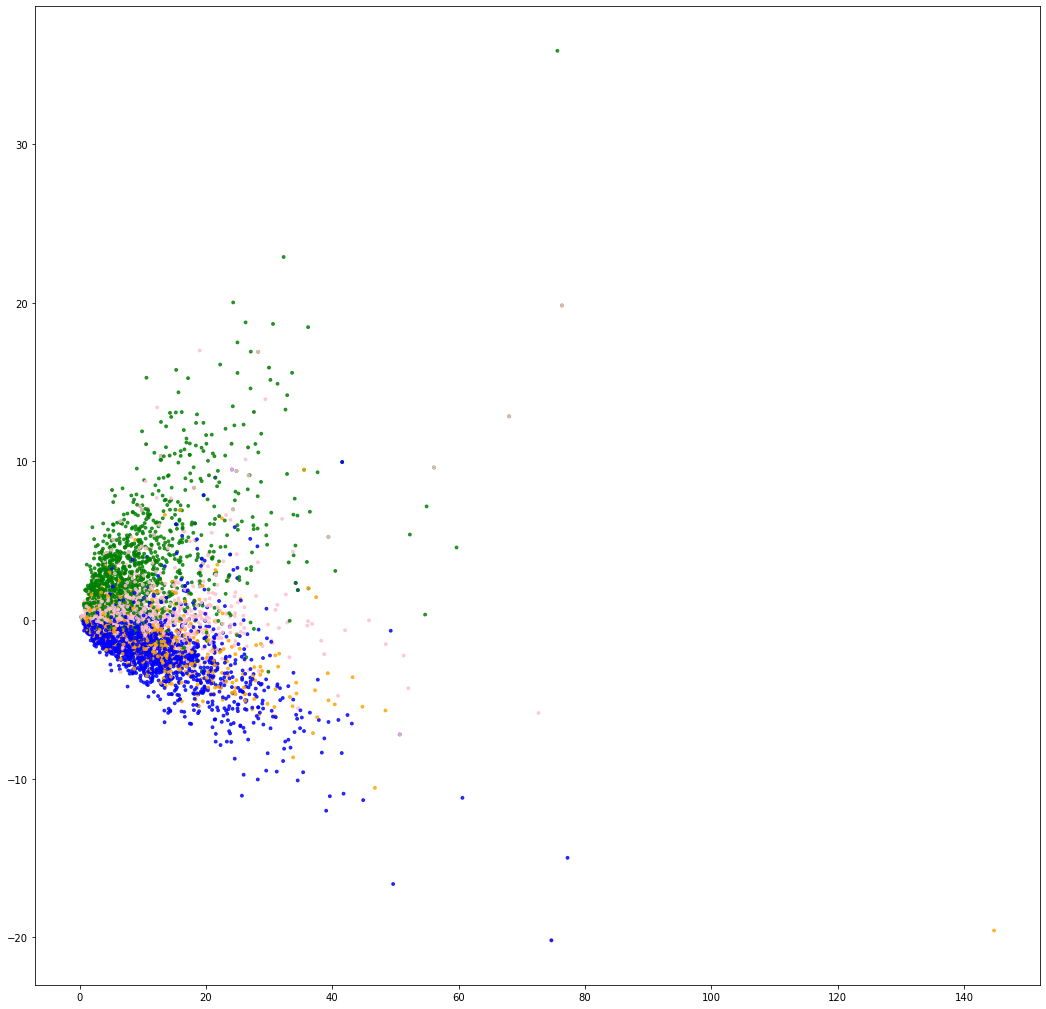

In [46]:
fig = plt.figure(figsize=(18, 18))          
try:    
    plot_LSA(X_train_counts_stemmed, y_train)
except:
    plot_LSA(X_train_counts_stemmed, y_train)
plt.show()

In [47]:
# Теперь метод главных компонент выглядит  лучше

In [48]:
logreg_stemmed = train_logreg_model(X_train_counts_stemmed, y_train)
y_predicted_counts_stemmed = logreg.predict(X_test_counts_stemmed)

cls done
fit done


accuracy = 0.638, precision = 0.659, recall = 0.638, f1 = 0.636
{'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}


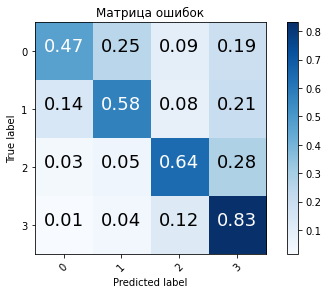

In [49]:
accuracy, precision, recall, f1 = eval_prediction(y_test, y_predicted_counts_stemmed, True)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")
print(label_encoding)

Удивительно! Стало хуже! Но при этом намного лучше стало отслеживание вкладов, а ипотеки, наоборот, хуже. Этот классификатор нам не подходит - качество ниже, чем у предыдущего.

In [50]:
importance_stemmed = get_most_important_features(count_vectorizer_stemmed, logreg_stemmed, 20) 

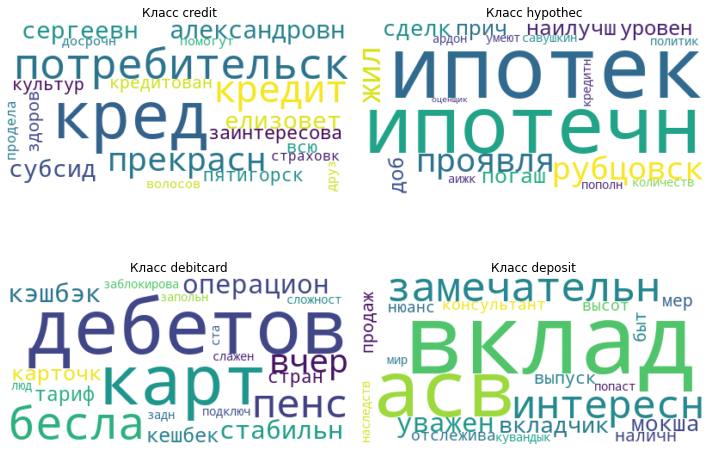

In [51]:
plot_most_important_features(importance_stemmed) # 

Теперь облака слов выглядят получше, хоть всё ещё встречаются повторы. Однако, при этом качество модели не улучшилось, а только ухудшилось.  

Тогда к нам на помощь спешит TF-IDF.

#### TF-IDF мешок слов

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [128]:
# X_train_tfidf.toarray().sum()

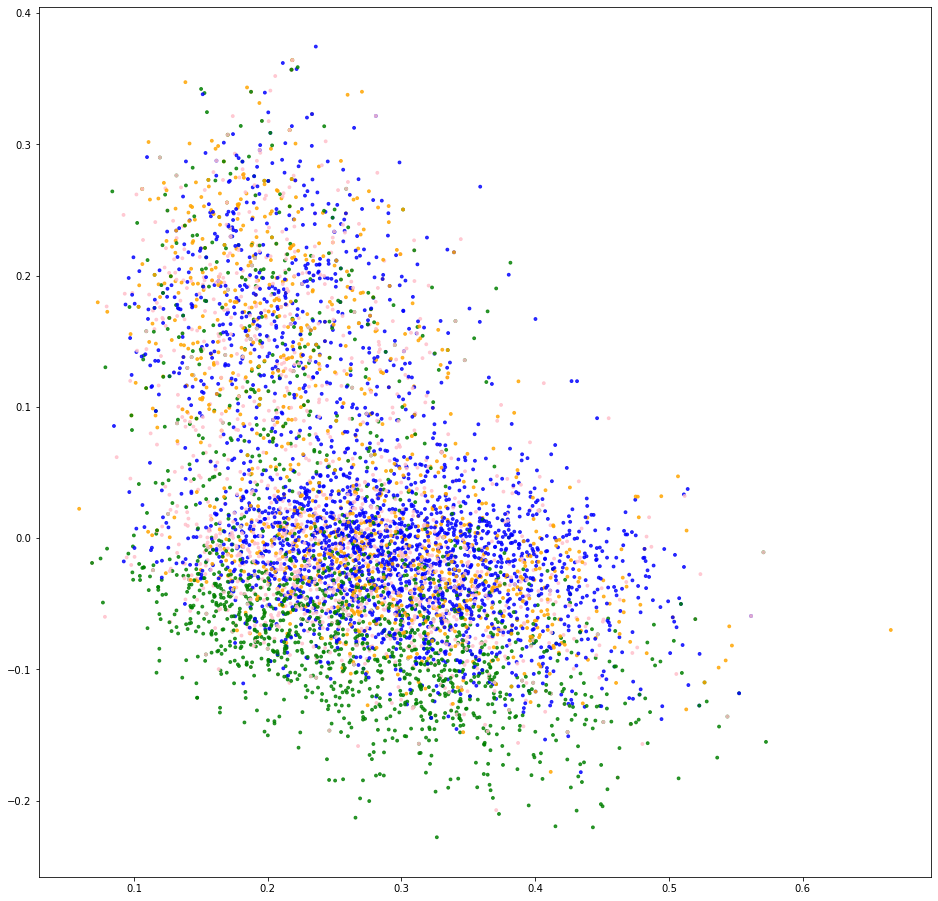

In [53]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Теперь классы комментариев становсятся более различимыми, и шкала сильно сократилась. Это заслуга взвешенного мешка слов!

In [54]:
logreg_tfidf = train_logreg_model(X_train_tfidf, y_train)
y_predicted_tfidf = logreg_tfidf.predict(X_test_tfidf)

cls done
fit done


accuracy = 0.767, precision = 0.770, recall = 0.767, f1 = 0.768
{'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}


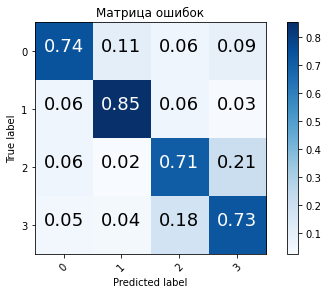

In [57]:
accuracy, precision, recall, f1 = eval_prediction(y_test, y_predicted_tfidf, True)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")
print(label_encoding)

Видим заметное улучшение классификатора в деле угадывания кредита (рост почти на 0.10). Это добавляет нашей модели сбалансированность. Также наблюдаем рост метрик до ~78%. Рост в 2-2.5% - неплохой показатель. 

In [58]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, logreg_tfidf, 20) 

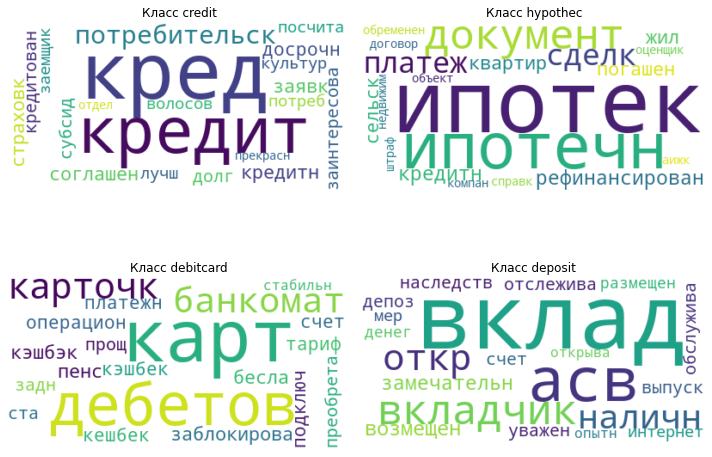

In [59]:
plot_most_important_features(importance_tfidf)

Облако слов отражает улучшение ситуации - роль слов, отражающих название класса, увеличилась. Также стало меньше бессмысленных слов типа нащваний населенных пунктов и отчеств. 

Мы могли бы использовать word2vec, но на обработку и тэггинг слов затрачивается слишком много ресурсов. Поясню - для русской реализации word2vec необходимо назначить каждому слову его часть речи ("пожар" (существительное) -> "пожар_NOUN"). Для подобной токенизации потребуется слишком много ресурсов, потому сначала реализуем сверточную нейросеть для текста, а потом придумаем, что делать с word2vec. Как вариант, заменить word2vec на BERT.  

### word2vec

#### Модель на имеющихся данных

In [117]:
import gensim
from gensim.models.word2vec import Word2Vec

In [225]:
# обучим модель на токенах
word2vec = Word2Vec(reviews_clear_df['tokens_nstop'], workers=4, size=300)

In [231]:
# функция для нахождения среднего в векторных представлениях слов
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# функция получения embedding'ов для слолбца DataFrame'а
def get_word2vec_embeddings(vectors, df, field='tokens_nstop', generate_missing=False):
    embeddings = df[field].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [227]:
embeddings = get_word2vec_embeddings(word2vec, reviews_clear_df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

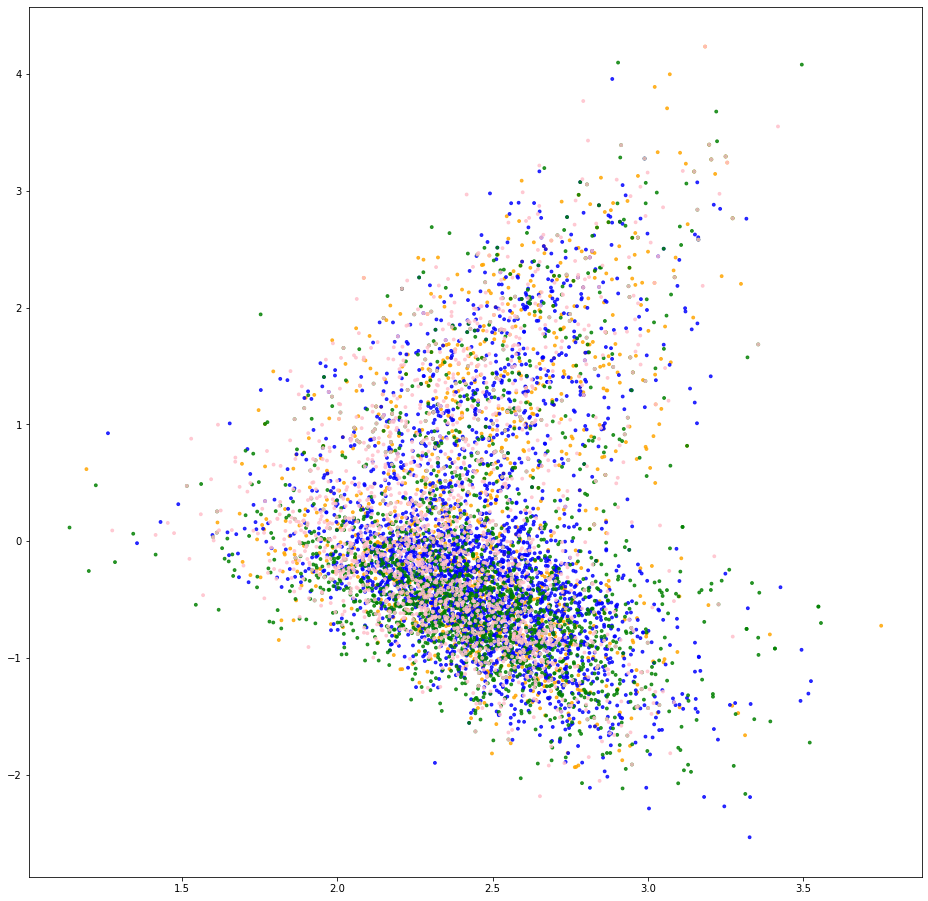

In [230]:
fig = plt.figure(figsize=(16, 16))          
try:
    plot_LSA(embeddings, list_labels)
except:
    plot_LSA(embeddings, list_labels)
plt.show() 

Embedding'и довольно сильно смешаны.

In [ ]:
logreg_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
logreg_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = logreg_w2v.predict(X_test_word2vec)

In [ ]:
accuracy, precision, recall, f1 = eval_prediction(y_test_word2vec, y_predicted_word2vec, True)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")
print(label_encoding)

#### Внешняя модель

[Русская реализация word2vec](https://github.com/RaRe-Technologies/gensim-data/issues/3). Используем одну из этих [моделей](https://rusvectores.org/en/models/). Например, <code>ruwikiruscorpora_upos_skipgram_300_2_2018</code>. Эта модель используется библиотекой gensim для создания векторных представлений слов (embeddings).

In [131]:
import gensim.downloader as api

In [260]:
import gensim
import gensim.downloader as api

word2vec_outer = api.load("word2vec-ruscorpora-300")
# word2vec_path = 'taiga_upos_skipgram_300_2_2018.vec.gz' 
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=False) # занимает около 3х минут

In [258]:
import json
info = api.info()
print(json.dumps(info, indent=4))

{
    "corpora": {
        "semeval-2016-2017-task3-subtaskBC": {
            "num_records": -1,
            "record_format": "dict",
            "file_size": 6344358,
            "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py",
            "license": "All files released for the task are free for general research use",
            "fields": {
                "2016-train": [
                    "..."
                ],
                "2016-dev": [
                    "..."
                ],
                "2017-test": [
                    "..."
                ],
                "2016-test": [
                    "..."
                ]
            },
            "description": "SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collect

Модель, скачанная извне, будет работать только с токенами, к которым прикреплена строка с информацией о части речи. Потому, надо провести дополнительную обработку текста. 

In [261]:
word2vec_outer.most_similar('консул_NOUN')[0]

('консульство_NOUN', 0.7268803119659424)

Возьмем токены, очищенные от стоп-слов, к которым применили лемматизацию (из секции о подготовке).  

In [262]:
embeddings = get_word2vec_embeddings(word2vec_outer, reviews_clear_df, field='tokens_nstop_lemm_pos')
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

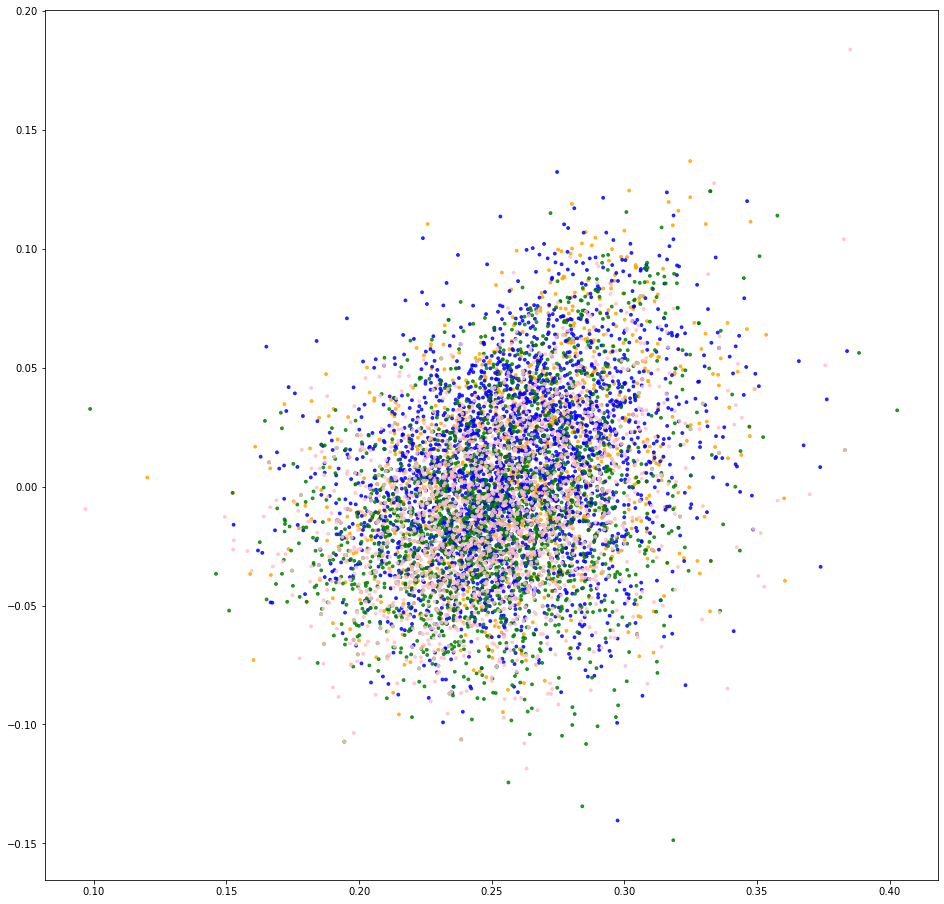

In [263]:
fig = plt.figure(figsize=(16, 16))          
try:
    plot_LSA(embeddings, list_labels)
except:
    plot_LSA(embeddings, list_labels)
plt.show() 

Embedding'и довольно сильно смешаны.

In [264]:
logreg_w2v_outer = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
logreg_w2v_outer.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = logreg_w2v.predict(X_test_word2vec)

accuracy = 0.774, precision = 0.791, recall = 0.774, f1 = 0.778
{'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}


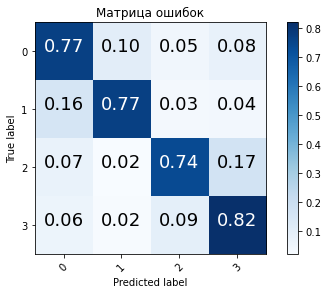

In [265]:
accuracy, precision, recall, f1 = eval_prediction(y_test_word2vec, y_predicted_word2vec, True)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")
print(label_encoding)